In [1]:
!pip install -q keras-facenet kaggle


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.1 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()  # upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d atulanandjha/lfwpeople
!unzip -q lfwpeople.zip
!tar -xzf lfw-funneled.tgz


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
 66% 153M/232M [00:00<00:00, 1.59GB/s]
100% 232M/232M [00:00<00:00, 984MB/s] 


In [4]:
import os, random, numpy as np, tensorflow as tf
from keras_facenet import FaceNet
from sklearn.model_selection import train_test_split


In [5]:
IMG_SIZE = 160
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

In [30]:
DATA_DIR = '/content/lfw_funneled/'
people = [
    p for p in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, p))
    and len(os.listdir(os.path.join(DATA_DIR, p))) >= 2
]

print("Number of identities:", len(people))


Number of identities: 1680


In [31]:
def create_pairs(data_dir, people, pairs_per_person=10):
    pairs, labels = [], []

    for person in people:
        imgs = os.listdir(os.path.join(data_dir, person))

        # Positive pairs
        for _ in range(pairs_per_person):
            img1, img2 = random.sample(imgs, 2)
            pairs.append([
                os.path.join(data_dir, person, img1),
                os.path.join(data_dir, person, img2)
            ])
            labels.append(1)

        # Negative pairs
        for _ in range(pairs_per_person):
            other = random.choice([p for p in people if p != person])
            img1 = random.choice(imgs)
            img2 = random.choice(os.listdir(os.path.join(data_dir, other)))

            pairs.append([
                os.path.join(data_dir, person, img1),
                os.path.join(data_dir, other, img2)
            ])
            labels.append(0)

    return np.array(pairs), np.array(labels)


In [32]:
pairs, labels = create_pairs(DATA_DIR, people, pairs_per_person=10)

pairs_train, pairs_tmp, y_train, y_tmp = train_test_split(
    pairs, labels, test_size=0.3, random_state=42
)

pairs_val, pairs_test, y_val, y_test = train_test_split(
    pairs_tmp, y_tmp, test_size=0.5, random_state=42
)


In [33]:
def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img


In [34]:
def make_dataset(pairs, labels):
    ds = tf.data.Dataset.from_tensor_slices((pairs, labels))

    def load_pair(pair, label):
        img1 = preprocess_image(pair[0])
        img2 = preprocess_image(pair[1])
        return (img1, img2), label

    ds = ds.map(load_pair, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


In [35]:
train_ds = make_dataset(pairs_train, y_train)
val_ds   = make_dataset(pairs_val, y_val)
test_ds  = make_dataset(pairs_test, y_test)


In [36]:
facenet = FaceNet()
facenet.model.trainable = False


In [40]:
def embedding_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = facenet.model(inputs)
    x = tf.keras.layers.Dense(128, activation="relu")(x)  # trainable
    x = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    return tf.keras.Model(inputs, x)

In [41]:
embedder = embedding_model()


In [42]:
input_1 = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
input_2 = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

emb_1 = embedder(input_1)
emb_2 = embedder(input_2)

distance = tf.keras.layers.Lambda(
    lambda x: tf.norm(x[0] - x[1], axis=1, keepdims=True)
)([emb_1, emb_2])

siamese_model = tf.keras.Model([input_1, input_2], distance)


In [43]:
def contrastive_loss(y_true, y_pred, margin=1.5):
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(
        y_true * tf.square(y_pred) +
        (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    )


In [44]:
siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=contrastive_loss
)


In [45]:
siamese_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 128)       │ 23,563,088 │ input_layer_8[0]… │
│ (Functional)        │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_45 (Lambda)  │ (None, 1)         │          0 │ functional_2[0][… │
│                     │                   │            │ functional_2[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,563,088 (89.89 MB)

 Trainable params: 65,664 (256.50 KB)

 Non-trainable params: 23,497,424 (89.64 MB)

In [46]:
history = siamese_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 109s 107ms/step - loss: 0.3109 - val_loss: 0.2398
Epoch 2/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 63s 86ms/step - loss: 0.2299 - val_loss: 0.2070
Epoch 3/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - loss: 0.2015 - val_loss: 0.1938
Epoch 4/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 72s 98ms/step - loss: 0.1897 - val_loss: 0.1874
Epoch 5/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 72s 98ms/step - loss: 0.1833 - val_loss: 0.1837


In [47]:
def compute_accuracy(model, dataset, threshold):
    correct, total = 0, 0
    for (img1, img2), labels in dataset:
        dists = model.predict([img1, img2], verbose=0)
        preds = (dists < threshold).astype(int)
        correct += (preds.flatten() == labels.numpy()).sum()
        total += labels.shape[0]
    return correct / total


In [48]:
def collect_distances_labels(model, dataset):
    distances, labels = [], []

    for (img1, img2), y in dataset:
        d = model.predict([img1, img2], verbose=0)
        distances.extend(d.flatten())
        labels.extend(y.numpy())

    return np.array(distances), np.array(labels)
val_dist, val_labels = collect_distances_labels(siamese_model, val_ds)


In [50]:
best_t, best_acc = 0, 0

for t in np.linspace(0.3, 1.2, 50):
    preds = (val_dist < t).astype(int)
    acc = (preds == val_labels).mean()

    if acc > best_acc:
        best_acc, best_t = acc, t


In [51]:

print("Best threshold:", best_t)
print("Validation Accuracy:", best_acc)


Best threshold: 0.7959183673469388
Validation Accuracy: 0.9392857142857143


In [52]:
test_acc = compute_accuracy(siamese_model, test_ds, best_t)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")


Final Test Accuracy: 93.59%


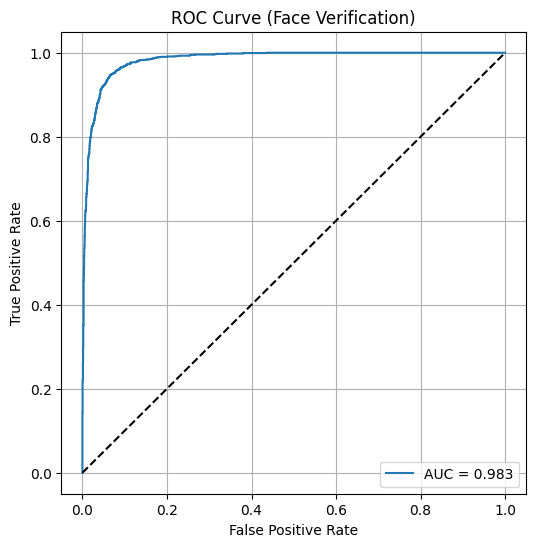

In [53]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# IMPORTANT:
# Positive class = same person → smaller distance
scores = -val_dist

fpr, tpr, thresholds = roc_curve(val_labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Face Verification)")
plt.legend()
plt.grid()
plt.show()


In [54]:
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))

eer = fpr[eer_idx]
eer_threshold = -thresholds[eer_idx]

print(f"EER: {eer*100:.2f}%")
print(f"EER Threshold: {eer_threshold:.3f}")


EER: 6.18%
EER Threshold: 0.766


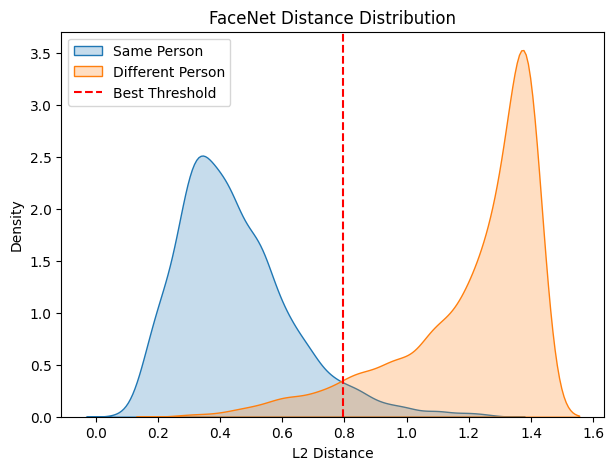

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

same = val_dist[val_labels == 1]
diff = val_dist[val_labels == 0]

plt.figure(figsize=(7,5))
sns.kdeplot(same, label="Same Person", fill=True)
sns.kdeplot(diff, label="Different Person", fill=True)
plt.axvline(best_t, color='r', linestyle='--', label="Best Threshold")
plt.xlabel("L2 Distance")
plt.ylabel("Density")
plt.title("FaceNet Distance Distribution")
plt.legend()
plt.show()


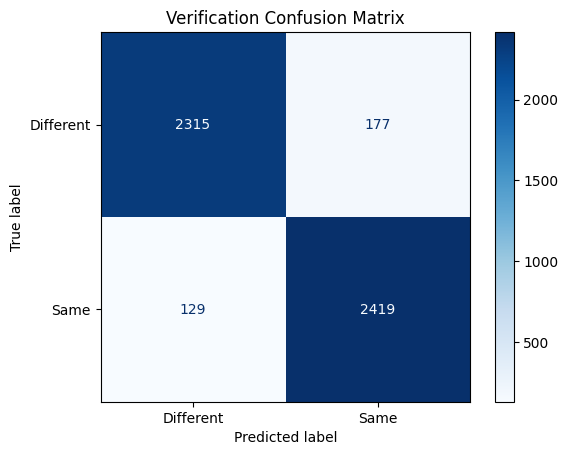

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = (val_dist < best_t).astype(int)
cm = confusion_matrix(val_labels, preds)

disp = ConfusionMatrixDisplay(cm, display_labels=["Different", "Same"])
disp.plot(cmap="Blues")
plt.title("Verification Confusion Matrix")
plt.show()


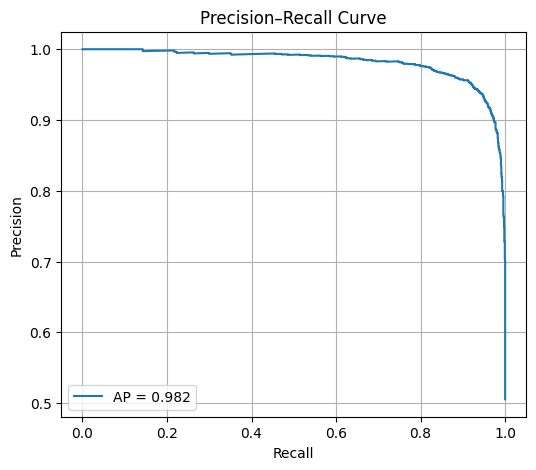

In [56]:
from sklearn.metrics import precision_recall_curve, average_precision_score

scores = -val_dist
precision, recall, _ = precision_recall_curve(val_labels, scores)
ap = average_precision_score(val_labels, scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid()
plt.show()


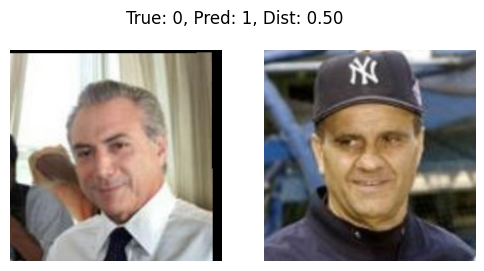

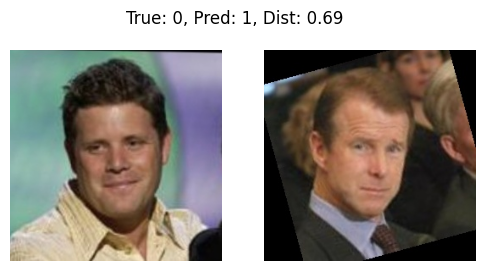

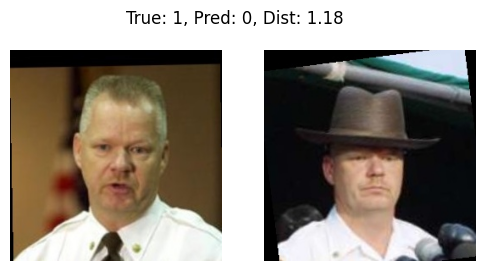

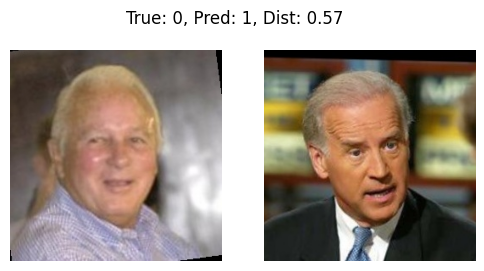

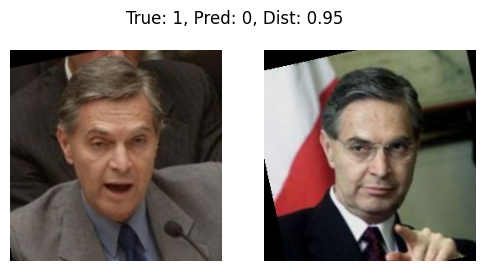

In [55]:
import matplotlib.pyplot as plt
from PIL import Image

def show_errors(pairs, distances, labels, threshold, max_show=5):
    preds = (distances < threshold).astype(int)
    errors = np.where(preds != labels)[0][:max_show]

    for idx in errors:
        img1 = Image.open(pairs_val[idx][0])
        img2 = Image.open(pairs_val[idx][1])

        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(img1); plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(img2); plt.axis("off")

        title = f"True: {labels[idx]}, Pred: {preds[idx]}, Dist: {distances[idx]:.2f}"
        plt.suptitle(title)
        plt.show()
show_errors(pairs_val, val_dist, val_labels, best_t)
